In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import re
import math
from dotenv import load_dotenv
import os
import requests

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from pysentimiento.preprocessing import preprocess_tweet
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
pickle_file_path = '~/data/train.pickle'
with open(pickle_file_path, 'rb') as f:
    train = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '~/data/train.pickle'

In [ ]:
pickle_file_path = '~/data/test_kaggle.pickle'
with open(pickle_file_path, 'rb') as f:
    test = pickle.load(f)

In [ ]:
df = pd.DataFrame(train)
df_test = pd.DataFrame(test)
df.head()

,price,title,loc_string,loc,features,type,subtype,selltype,desc
0,320.000 €,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,"[85 m2, 2 hab., 1 baño, 3.647 €/m2]",FLAT,FLAT,SECOND_HAND,Piso en última planta a reformar en calle Tall...
1,335.000 €,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,"[65 m2, 2 hab., 1 baño, 5.000 €/m2]",FLAT,FLAT,SECOND_HAND,"Ubicado en la zona del Camp de l’Arpa, cerca d..."
2,330.000 €,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,"[77 m2, 2 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,"En pleno centro de Barcelona, justo al lado de..."
3,435.000 €,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,"[96 m2, 3 hab., 2 baños, 4.531 €/m2]",FLAT,FLAT,SECOND_HAND,"Vivienda espaciosa en Sant Antoni, cerca de Pl..."
4,410.000 €,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,"[84 m2, 2 hab., 1 baño, 4.881 €/m2]",FLAT,FLAT,SECOND_HAND,"En el corazón de Barcelona, en una hermosa fin..."


## 1) Numerical features

In [ ]:
df['price'] = df['price'].str.replace(' €', '').str.replace('.', '').astype(float) / 1000

/var/folders/pf/yq0p17ss3ydb5hldysbbgx700000gn/T/ipykernel_71620/1704380930.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace(' €', '').str.replace('.', '').astype(float) / 1000


In [ ]:
df = df.drop('subtype', axis=1)

In [ ]:
df['sq_meters'] = df['features'].str[0].str.extract('(\d+)').astype(float)
df['num_rooms'] = df['features'].str[1].str.extract('(\d+)').astype(float)
df['num_bathrooms'] = df['features'].str[2].str.extract('(\d+)').astype(float)

In [ ]:
df_lat_long = pd.read_csv('location_data/latitude_longitude.csv')

In [ ]:
df['latitude'] = df_lat_long['Latitude']
df['longitude'] = df_lat_long['Longitude']

In [ ]:
df = df.drop('selltype', axis=1)

In [ ]:
df['type'].value_counts()

FLAT            806
APARTMENT        19
PENTHOUSE        14
DUPLEX           11
GROUND_FLOOR      7
STUDIO            6
LOFT              3
Name: type, dtype: int64

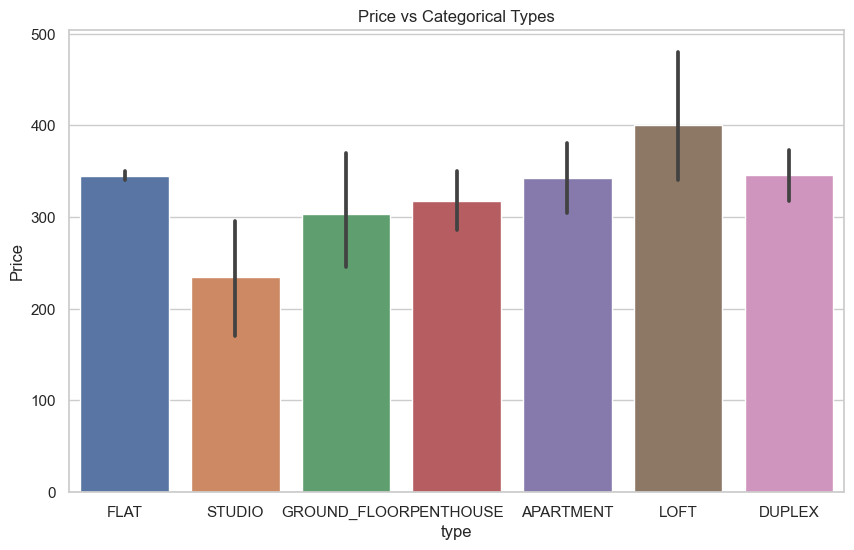

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='price', data=df)
plt.title('Price vs Categorical Types')
plt.xlabel('type')
plt.ylabel('Price')
plt.show()

### 1a) Handling type features - label encoder

In [ ]:
df_label_encoder = df.copy()

In [ ]:
# Encode categorical features
label_encoders = {}
for col in ['type']:
    label_encoders[col] = LabelEncoder()
    df_label_encoder[col] = label_encoders[col].fit_transform(df_label_encoder[col])

#### 1a)a) label TF-IDF

In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\sáéíóúüñ]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text, language='spanish')
    
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize tokens
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [ ]:
df_label_encoder_tf = df_label_encoder.copy()

In [ ]:
df_label_encoder_tf['preprocessed_desc'] = df_label_encoder_tf['desc'].apply(preprocess_text)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
desc_tfidf = tfidf_vectorizer.fit_transform(df_label_encoder_tf['preprocessed_desc'] )

In [ ]:
desc_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.13007661, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02770014, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02864773, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
df_label_encoder_tf.columns

Index(['price', 'title', 'loc_string', 'loc', 'features', 'type', 'desc',
       'sq_meters', 'num_rooms', 'num_bathrooms', 'latitude', 'longitude',
       'preprocessed_desc'],
      dtype='object')

In [ ]:
df_label_encoder_tf = df_label_encoder_tf.drop(['title','loc_string','loc','features','desc','preprocessed_desc'], axis=1)

In [ ]:
df_label_encoder_tf.columns

Index(['price', 'type', 'sq_meters', 'num_rooms', 'num_bathrooms', 'latitude',
       'longitude'],
      dtype='object')

##### Model XGBoost

In [ ]:
y = df_label_encoder_tf['price']
df_label_encoder_tf = df_label_encoder_tf.drop('price', axis=1)

In [ ]:
X_numerical = df_label_encoder_tf

X_combined = np.concatenate((X_numerical, desc_tfidf.toarray()), axis=1)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
# Train the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R Square: {r2}")

R Square: 0.6246669084172224


#### 1a)b) Robertuito embeddings

In [ ]:
# df_label_encoder_emb = df_label_encoder.copy()

In [ ]:
# tokenizer_length = 128

In [ ]:
# model_name = "pysentimiento/robertuito-base-uncased"

# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=3
# )
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.model_max_length = tokenizer_length

# df_label_encoder_emb["preprocessed_desc"] = df_label_encoder_emb["desc"].map(lambda text: {"desc": preprocess_tweet(text, lang="es")})

# batch_size = 32

# num_batches = math.ceil(len(df_label_encoder_emb) / batch_size)
# tokenized_texts = []

# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = (i + 1) * batch_size
#     batch_texts = df_label_encoder_emb["preprocessed_desc"]\
#         .iloc[start_idx:end_idx].apply(lambda text: 
#         tokenizer(text["desc"], 
#         padding="max_length", 
#         truncation=True, 
#         max_length=tokenizer_length))
#     tokenized_texts.extend(batch_texts)

# df_label_encoder_emb["tokenized_embeddings"] = tokenized_texts

In [ ]:
# df_label_encoder_emb["input_ids"] = df_label_encoder_emb["tokenized_embeddings"].apply(lambda embeddings: embeddings["input_ids"])

In [ ]:
# features_df = pd.DataFrame(df_label_encoder_emb["input_ids"].to_list(), columns=[f"feature_{i}" for i in range(tokenizer_length)])

# df_label_encoder_emb= pd.concat([df_label_encoder_emb, features_df], axis=1)

In [ ]:
# df_label_encoder_emb = df_label_encoder_emb.drop(['title', 'loc_string', 'loc', 'features','desc','preprocessed_desc', 'tokenized_embeddings', 'input_ids'], axis=1)

In [ ]:
# df_label_encoder_tf.columns

In [ ]:
# df_label_encoder_emb.columns[0:8]

In [ ]:
# X = df_label_encoder_emb.drop('price', axis=1)
# y = df_label_encoder_emb['price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# model = XGBRegressor()
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # # Evaluate the model
# r2 = r2_score(y_test, y_pred)
# print(f"R Square: {r2}")

### 1b) Handling type features - dummy encoding

In [ ]:
# df_dummy_encoder = df.copy()

In [ ]:
# type_dummies = pd.get_dummies(df_dummy_encoder['type'], prefix='type')
# df_dummy_encoder = pd.concat([df_dummy_encoder,type_dummies], axis=1)

In [ ]:
# df_dummy_encoder = df_dummy_encoder.drop('type', axis=1)

#### 1a)a) dummy TF-IDF

In [ ]:
# df_dummy_encoder_tf = df_dummy_encoder.copy()

In [ ]:
# df_dummy_encoder_tf['preprocessed_desc'] = df_dummy_encoder_tf['desc'].apply(preprocess_text)

In [ ]:
# tfidf_vectorizer = TfidfVectorizer()
# desc_tfidf = tfidf_vectorizer.fit_transform(df_dummy_encoder_tf['preprocessed_desc'] )

In [ ]:
# df_dummy_encoder_tf = df_dummy_encoder_tf.drop(['title','loc_string','loc','features','desc','preprocessed_desc'], axis=1)

In [ ]:
# df_dummy_encoder_tf.columns

##### Model XGBoost

In [ ]:
# y = df_dummy_encoder_tf['price']
# df_dummy_encoder_tf = df_dummy_encoder_tf.drop('price', axis=1)

In [ ]:
# X_numerical = df_dummy_encoder_tf
# X_combined = np.concatenate((X_numerical, desc_tfidf.toarray()), axis=1)

In [ ]:
# df_dummy_encoder_tf.columns

In [ ]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
# # Train the model
# model = XGBRegressor()
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluate the model
# r2 = r2_score(y_test, y_pred)
# print(f"R Square: {r2}")

In [ ]:
# # Make predictions on the test set
# y_pred = model.predict(X_train)

# # Evaluate the model
# r2 = r2_score(y_train, y_pred)
# print(f"R Square: {r2}")

# Testing data prediction

In [ ]:
df_test = df_test.drop('subtype', axis=1)

In [ ]:
df_test['sq_meters'] = df_test['features'].str[0].str.extract('(\d+)').astype(float)
df_test['num_rooms'] = df_test['features'].str[1].str.extract('(\d+)').astype(float)
df_test['num_bathrooms'] = df_test['features'].str[2].str.extract('(\d+)').astype(float)

In [ ]:
# Load variables from .env file
load_dotenv()

# Access variables using os.getenv()
api_key = os.getenv("geocode_api_key")

In [ ]:
# def geocode_location(location, api_key):
#     base_url = "https://maps.googleapis.com/maps/api/geocode/json"
#     params = {
#         'address': location,
#         'key': api_key,
#     }

#     response = requests.get(base_url, params=params)
#     data = response.json()

#     if response.status_code == 200 and data['status'] == 'OK':
#         # Extract latitude and longitude
#         lat = data['results'][0]['geometry']['location']['lat']
#         lng = data['results'][0]['geometry']['location']['lng']
#         return lat, lng
#     else:
#         print(f"Geocoding failed. Status Code: {response.status_code}, Status: {data['status']}")
#         return None

In [ ]:
# df_test[['Latitude', 'Longitude']] = df_test['loc_string'].apply(lambda loc: pd.Series(geocode_location(loc, api_key) if geocode_location(loc, api_key) else [None, None]))

In [ ]:
df_lat_long_test = pd.read_csv('location_data/longitude_latitude_test.csv')

In [ ]:
df_test['Latitude'] = df_lat_long_test['Latitude']
df_test['Longitude'] = df_lat_long_test['Longitude']

In [ ]:
df_test['selltype'].unique()

array(['SECOND_HAND'], dtype=object)

In [ ]:
df_test = df_test.drop('selltype', axis=1)

In [ ]:
# df_test.to_csv('longitude_latitude_test.csv')

In [ ]:
df_test[['description','desc']]

,description,desc
0,Contactar con Camila 7. 3. La Casa Agency Estu...,Contactar con Camila 7. 3.\n\nLa Casa Agency E...
1,¡Un gran piso a reformar es una gran oportunid...,¡Un gran piso a reformar es una gran oportunid...
2,"AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...","AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME..."
3,"Piso en pleno centro de Poblenou, techos altos...","Piso en pleno centro de Poblenou, techos altos..."
4,Punt Zona Franca presenta esta fantástica vivi...,Punt Zona Franca presenta esta fantástica vivi...
...,...,...
127,"Piso totalmente exterior con balcón, a 2 calle...",Encantador piso alto todo exterior con 2 balco...
128,Estupenda oportunidad en el Parc i La Llacuna ...,Estupenda oportunidad en el Parc i La Llacuna ...
129,¡OPORTUNIDAD EN SAGRADA FAMILIA! Piso situado ...,¡OPORTUNIDAD EN SAGRADA FAMILIA!\n\nPiso situa...
130,"Piso en venta, Barcelona, Poblenou, carrer del...","Piso en venta, Barcelona, Poblenou, carrer del..."


In [ ]:
df_test = df_test.drop('description', axis=1)

In [ ]:
for col in ['type']:
    df_test[col] = label_encoders[col].transform(df_test[col])

In [ ]:
df_test['preprocessed_desc'] = df_test['desc'].apply(preprocess_text)

In [ ]:
desc_tfidf_test = tfidf_vectorizer.transform(df_test['preprocessed_desc'] )

In [ ]:
df_test = df_test.drop(['title','loc_string','loc','features','desc','id','preprocessed_desc'], axis=1)

In [ ]:
df_test.columns

Index(['type', 'sq_meters', 'num_rooms', 'num_bathrooms', 'Latitude',
       'Longitude'],
      dtype='object')

In [ ]:
df_label_encoder_tf.columns

Index(['type', 'sq_meters', 'num_rooms', 'num_bathrooms', 'latitude',
       'longitude'],
      dtype='object')

In [ ]:
desc_tfidf_test.toarray().shape

(132, 4159)

In [ ]:
desc_tfidf.toarray().shape

(866, 4159)

In [ ]:
X_numerical_test = df_test

X_test = np.concatenate((X_numerical_test, desc_tfidf_test.toarray()), axis=1)

In [ ]:
X_test.shape

(132, 4165)

In [ ]:
X_combined.shape

(866, 4165)

In [ ]:
X_test

array([[2.00000000e+00, 8.70000000e+01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 7.80000000e+01, 4.00000000e+00, ...,
        1.64741506e-01, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 6.50000000e+01, 1.00000000e+00, ...,
        5.70553552e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.00000000e+00, 7.50000000e+01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.50000000e+01, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 8.00000000e+01, 4.00000000e+00, ...,
        3.27714302e-02, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
model = XGBRegressor()
model.fit(X_combined, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
df_test_id = pd.DataFrame(test)

In [ ]:
ids = df_test_id.id

In [ ]:
data = np.column_stack((ids, y_pred))

In [ ]:
df_pred = pd.DataFrame(data, columns=['id','price'])

In [ ]:
df_pred['id'] = df_pred['id'].astype(int)

In [ ]:
df_pred

,id,price
0,0,344.729462
1,1,334.242676
2,2,290.472870
3,3,372.527924
4,4,314.886505
...,...,...
127,127,372.405060
128,128,297.893127
129,129,340.664581
130,130,348.820770


In [ ]:
df_pred.to_csv('solution.csv', index=False)